In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model

In [3]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [7]:
data.head(45)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
data = data.fillna(method="ffill")

In [8]:
data.head(45)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 18794
Unique tags in corpus: 17


In [10]:
words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())


In [11]:
print("Unique tags are:", tags)

Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [12]:
num_words = len(words)
num_tags = len(tags)

In [13]:
num_words

18795

In [14]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [15]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [16]:
len(sentences)
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [17]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


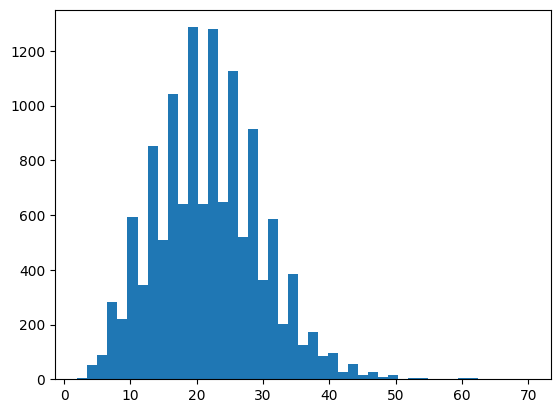

In [19]:
plt.hist([len(s) for s in sentences], bins=45)
plt.show()

In [20]:
X1 = [[word2idx[w[0]] for w in s] for s in sentences]

In [22]:
max_len = 45

In [23]:
nums = [[1], [2, 3], [4, 5, 6]]
sequence.pad_sequences(nums)

array([[0, 0, 1],
       [0, 2, 3],
       [4, 5, 6]], dtype=int32)

In [24]:
nums = [[1], [2, 3], [4, 5, 6]]
sequence.pad_sequences(nums,maxlen=2)

array([[0, 1],
       [2, 3],
       [5, 6]], dtype=int32)

In [25]:
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)

In [26]:
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]

In [27]:
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)
X_train[0]
y_train[0]


array([ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  3, 10,  0,  0,  0,  0,  0,
        7, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [30]:
input_word = layers.Input(shape=(max_len,))
embedding_layer= layers.Embedding(input_dim=num_words,output_dim=50,input_length=max_len)(input_word)
dropout_layer=layers.SpatialDropout1D(0.1)(embedding_layer)
bidirectional_lstm=layers.Bidirectional(layers.LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(dropout_layer)
output=layers.TimeDistributed(layers.Dense(num_tags,activation="softmax"))(bidirectional_lstm)
model = Model(input_word, output)
model.summary()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 45)]              0         
                                                                 
 embedding (Embedding)       (None, 45, 50)            939750    
                                                                 
 spatial_dropout1d (Spatial  (None, 45, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 45, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 45, 17)            3417      
 ributed)                                                        
                                                             

In [35]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=30,
    epochs=3,
)


Epoch 1/3
353/353 [==============================] - 36s 102ms/step - loss: 0.0621 - accuracy: 0.9826 - val_loss: 0.0770 - val_accuracy: 0.9783
Epoch 2/3
353/353 [==============================] - 37s 106ms/step - loss: 0.0477 - accuracy: 0.9860 - val_loss: 0.0741 - val_accuracy: 0.9794
Epoch 3/3
353/353 [==============================] - 36s 102ms/step - loss: 0.0394 - accuracy: 0.9883 - val_loss: 0.0729 - val_accuracy: 0.9799


In [32]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.390545,0.927170,0.190153,0.943221
1,0.153264,0.954721,0.123515,0.967436
2,0.090695,0.975052,0.088219,0.975575


<Axes: >

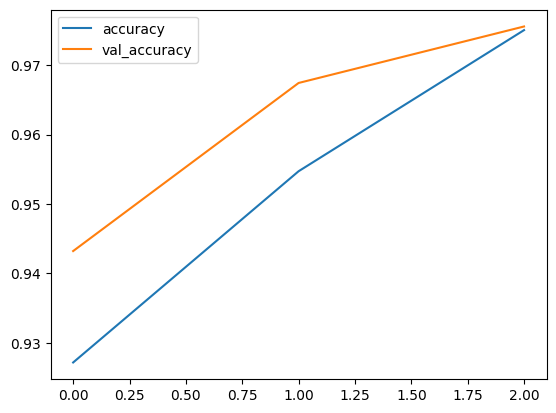

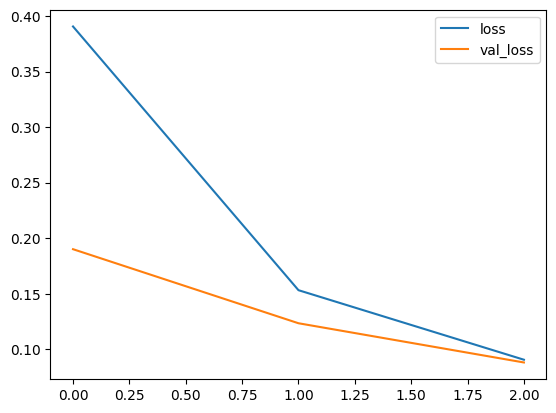

In [33]:
metrics[['accuracy','val_accuracy']].plot()
metrics[['loss','val_loss']].plot()

In [42]:
i = 29
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 29ms/step
Word           True 	 Pred

------------------------------
At             O	O
ceremonies     O	O
in             O	O
Oslo           B-geo	B-geo
,              O	O
Norway         B-geo	B-geo
,              O	O
Mr.            B-per	B-per
ElBaradei      I-per	I-per
stressed       O	O
the            O	O
importance     O	O
of             O	O
the            O	O
security       O	O
of             O	O
the            O	O
human          O	O
family         O	O
.              O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
5,500-member   O	O
